In [2]:

import os
import shutil
import warnings
import json
import re
import glob
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model, layers as keras_layers
from sklearn.model_selection import KFold
from classification_models.tfkeras import Classifiers
import shap

SEED = 0
warnings.filterwarnings("ignore")

In [3]:
def load_dataset(base_path, filename):
    return pd.read_csv(os.path.join(base_path, filename))

def prepare_dataset_for_shap(df, image_column, image_list):
    df[image_column] = df[image_column].apply(lambda x: x + '.jpg')
    df['target'] = df['target'].astype(str)
    return df[df[image_column].isin(image_list)]

database_base_path = 'C:/Datasets/melanoma_256/'
train = load_dataset(database_base_path, 'train.csv')
test = load_dataset(database_base_path, 'test.csv')
images_to_explain = ['ISIC_0074311.jpg', 'ISIC_0074542.jpg', 'ISIC_0075663.jpg', 'ISIC_0075914.jpg', 
                     'ISIC_0076262.jpg', 'ISIC_0082543.jpg', 'ISIC_0082934.jpg', 'ISIC_0083035.jpg', 
                     'ISIC_0084086.jpg', 'ISIC_0084270.jpg', 'ISIC_0149568.jpg', 'ISIC_0188432.jpg', 
                     'ISIC_0207268.jpg', 'ISIC_0232101.jpg', 'ISIC_0247330.jpg', 'ISIC_0528044.jpg', 
                     'ISIC_1219894.jpg', 'ISIC_2776906.jpg']
eval_df = prepare_dataset_for_shap(train, 'image_name', images_to_explain)


In [4]:
HEIGHT = 256
WIDTH = 256
CHANNELS = 3
BATCH_SIZE = 64
AUTO = tf.data.experimental.AUTOTUNE

# SHAP parameters
images_to_explain = ['ISIC_0074311.jpg', 'ISIC_0074542.jpg', 'ISIC_0075663.jpg', 'ISIC_0075914.jpg', 
                     'ISIC_0076262.jpg', 'ISIC_0082543.jpg', 'ISIC_0082934.jpg', 'ISIC_0083035.jpg', 
                     'ISIC_0084086.jpg', 'ISIC_0084270.jpg', 'ISIC_0149568.jpg', 'ISIC_0188432.jpg', 
                     'ISIC_0207268.jpg', 'ISIC_0232101.jpg', 'ISIC_0247330.jpg', 'ISIC_0528044.jpg', 
                     'ISIC_1219894.jpg', 'ISIC_2776906.jpg']

eval_df = train[train['image_name'].isin(images_to_explain)]

for filename in images_to_explain:
    shutil.copy('C:/Datasets/melanoma_256/train/' + filename, 'to_explain/')

In [5]:
# Datasets utility functions
UNLABELED_TFREC_FORMAT = {
    "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
    "image_name": tf.io.FixedLenFeature([], tf.string), # shape [] means single element
    # meta features
    "patient_id": tf.io.FixedLenFeature([], tf.int64),
    "sex": tf.io.FixedLenFeature([], tf.int64),
    "age_approx": tf.io.FixedLenFeature([], tf.int64),
    "anatom_site_general_challenge": tf.io.FixedLenFeature([], tf.int64),
}

def decode_image(image_data, height, width, channels):
    image = tf.image.decode_jpeg(image_data, channels=channels)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [height, width, channels])
    return image

# Test function
def read_unlabeled_tfrecord(example, height=HEIGHT, width=WIDTH, channels=CHANNELS):
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_tabular': data}, image_name # returns a dataset of (image, data, image_name)

def load_dataset_test(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_unlabeled_tfrecord, num_parallel_calls=buffer_size)
    # returns a dataset of (image, data, label, image_name) pairs if labeled=True or (image, data, image_name) pairs if labeled=False
    return dataset

def get_test_dataset(filenames, batch_size=32, buffer_size=-1):
    dataset = load_dataset_test(filenames, buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Custom SHAP plot
def image_plot(shap_values, pixel_values, labels=None, preds=None, names=None, width=20, aspect=0.2, hspace=0.2, labelpad=None, show=True, fig_size=None):
    """ Plots SHAP values for image inputs.
    Parameters
    ----------
    shap_values : [numpy.array]
        List of arrays of SHAP values. Each array has the shap (# samples x width x height x channels), and the
        length of the list is equal to the number of model outputs that are being explained.
    pixel_values : numpy.array
        Matrix of pixel values (# samples x width x height x channels) for each image. It should be the same
        shape as each array in the shap_values list of arrays.
    labels : list
        List of names for each of the model outputs that are being explained. This list should be the same length
        as the shap_values list.
    width : float
        The width of the produced matplotlib plot.
    labelpad : float
        How much padding to use around the model output labels.
    show : bool
        Whether matplotlib.pyplot.show() is called before returning. Setting this to False allows the plot
        to be customized further after it has been created.
    """

    multi_output = True
    if type(shap_values) != list:
        multi_output = False
        shap_values = [shap_values]

    # make sure labels
    if labels is not None:
        assert labels.shape[0] == shap_values[0].shape[0], "Labels must have same row count as shap_values arrays!"
        if multi_output:
            assert labels.shape[1] == len(shap_values), "Labels must have a column for each output in shap_values!"
        else:
            assert len(labels.shape) == 1, "Labels must be a vector for single output shap_values."

    label_kwargs = {} if labelpad is None else {'pad': labelpad}

    # plot our explanations
    x = pixel_values
    if fig_size is None:
        fig_size = np.array([3 * (len(shap_values) + 1), 2.5 * (x.shape[0] + 1)])
        if fig_size[0] > width:
            fig_size *= width / fig_size[0]
    fig, axes = plt.subplots(nrows=x.shape[0], ncols=len(shap_values) + 1, figsize=fig_size)
    if len(axes.shape) == 1:
        axes = axes.reshape(1,axes.size)
    for row in range(x.shape[0]):
        x_curr = x[row].copy()

        # make sure
        if len(x_curr.shape) == 3 and x_curr.shape[2] == 1:
            x_curr = x_curr.reshape(x_curr.shape[:2])
        if x_curr.max() > 1:
            x_curr /= 255.

        # get a grayscale version of the image
        if len(x_curr.shape) == 3 and x_curr.shape[2] == 3:
            x_curr_gray = (0.2989 * x_curr[:,:,0] + 0.5870 * x_curr[:,:,1] + 0.1140 * x_curr[:,:,2]) # rgb to gray
        else:
            x_curr_gray = x_curr

        axes[row,0].imshow(x_curr, cmap=plt.get_cmap('gray'))
        axes[row,0].set_title(f'Image: {names[row]}', **label_kwargs)
        axes[row,0].axis('off')
        if len(shap_values[0][row].shape) == 2:
            abs_vals = np.stack([np.abs(shap_values[i]) for i in range(len(shap_values))], 0).flatten()
        else:
            abs_vals = np.stack([np.abs(shap_values[i].sum(-1)) for i in range(len(shap_values))], 0).flatten()
        max_val = np.nanpercentile(abs_vals, 99.9)
        for i in range(len(shap_values)):
            if labels is not None:
                axes[row,i+1].set_title(f'Label: {labels[row,i]} Pred: {preds[row,i]:.2f}', **label_kwargs)
            sv = shap_values[i][row] if len(shap_values[i][row].shape) == 2 else shap_values[i][row].sum(-1)
            axes[row,i+1].imshow(x_curr_gray, cmap=plt.get_cmap('gray'), alpha=0.15, extent=(-1, sv.shape[1], sv.shape[0], -1))
            im = axes[row,i+1].imshow(sv, cmap=shap.plots.colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
            axes[row,i+1].axis('off')
    if hspace == 'auto':
        fig.tight_layout()
    else:
        fig.subplots_adjust(hspace=hspace)
    cb = fig.colorbar(im, ax=np.ravel(axes).tolist(), label="SHAP value", orientation="horizontal", aspect=fig_size[0]/aspect)
    cb.outline.set_visible(False)
    if show:
        plt.show()

In [14]:
def model_fn(input_shape):
    input_image = L.Input(shape=input_shape, name='input_image')
    ResNet18, preprocess_input = Classifiers.get('resnet18')
    base_model = ResNet18(input_shape=input_shape, 
                          weights=None, 
                          include_top=False)

    x = base_model(input_image)
    x = L.GlobalAveragePooling2D()(x)
    output = L.Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=input_image, outputs=output)
    
    return model

model = model_fn((HEIGHT, WIDTH, CHANNELS))
model.load_weights('C:/Datasets/ResNet_18.h5') # load pre-trained weights
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 model_2 (Functional)        (None, 8, 8, 512)         11186889  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 11,187,402
Trainable params: 11,179,460
Non-trainable params: 7,942
_________________________________________________________________


In [15]:
# data generator
eval_datagen = ImageDataGenerator(rescale=1./255)

eval_generator=eval_datagen.flow_from_dataframe(
    dataframe=eval_df,
    directory='to_explain/',
    x_col='image_name',
    y_col='target',
    class_mode='binary', 
    batch_size=BATCH_SIZE,   
    target_size=(HEIGHT, WIDTH),
    shuffle=False,
    seed=SEED)

# add predictions
eval_df['preds'] = model.predict(eval_generator)
display(eval_df.head())

Found 18 validated image filenames belonging to 2 classes.
1/1 [==============================] - 3s 3s/step


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,preds
5,ISIC_0074311.jpg,IP_2950485,female,40.0,lower extremity,unknown,benign,0,1,6000,4000,0.029171
6,ISIC_0074542.jpg,IP_4698288,male,25.0,lower extremity,unknown,benign,0,14,5184,3456,0.025944
7,ISIC_0075663.jpg,IP_6017204,female,35.0,torso,unknown,benign,0,11,2592,1936,0.014801
8,ISIC_0075914.jpg,IP_7622888,male,30.0,torso,unknown,benign,0,0,6000,4000,0.021398
9,ISIC_0076262.jpg,IP_5075533,female,50.0,lower extremity,unknown,benign,0,9,6000,4000,0.041129


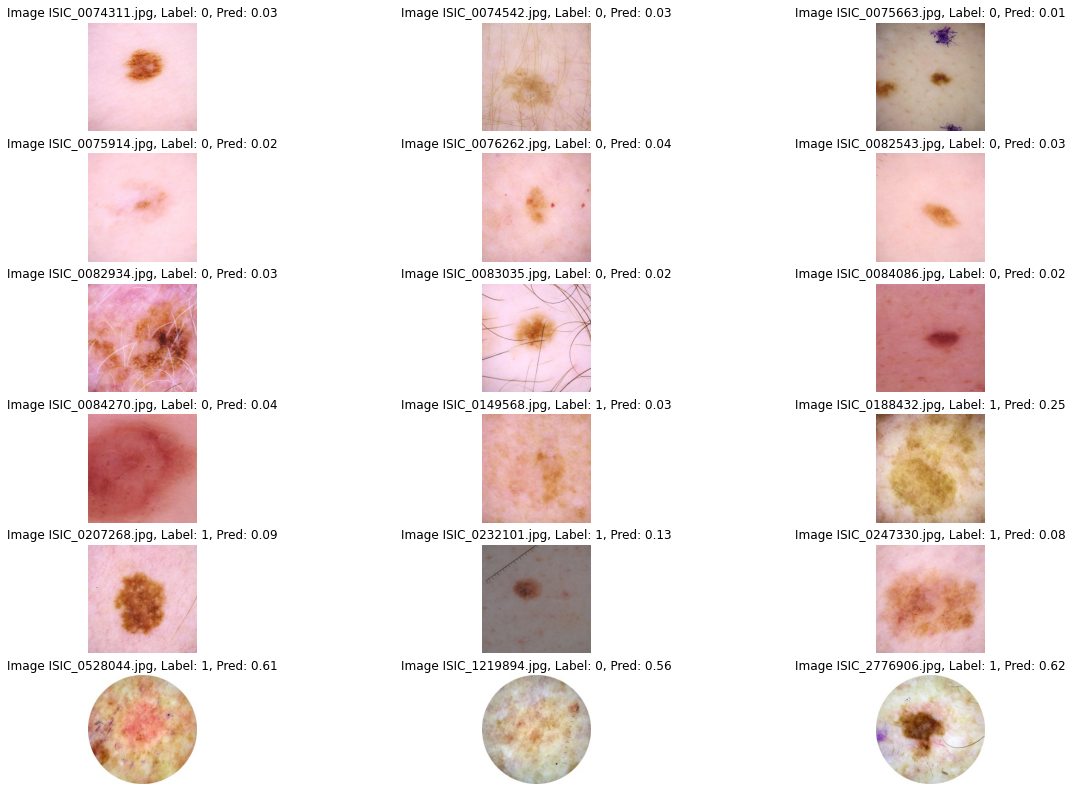

In [16]:
n_explain = 18
eval_generator.batch_size = n_explain # background dataset
background, lbls = next(eval_generator)
lbls = lbls.reshape(lbls.shape[0], 1)

fig, axes = plt.subplots(6, 3, figsize=(20, 14))
axes = axes.flatten()
for x in range(6):
    axes[x].imshow(background[x])
    axes[x+6].imshow(background[x+6])
    axes[x+12].imshow(background[x+12])
    
    axes[x].set_title(f"Image {eval_df['image_name'].values[x]}, Label: {eval_df['target'].values[x]}, Pred: {eval_df['preds'].values[x]:.2f}")
    axes[x+6].set_title(f"Image {eval_df['image_name'].values[x+6]}, Label: {eval_df['target'].values[x+6]}, Pred: {eval_df['preds'].values[x+6]:.2f}")
    axes[x+12].set_title(f"Image {eval_df['image_name'].values[x+12]}, Label: {eval_df['target'].values[x+12]}, Pred: {eval_df['preds'].values[x+12]:.2f}")
    
    axes[x].set_axis_off()
    axes[x+6].set_axis_off()
    axes[x+12].set_axis_off()
    
plt.show()

As we can see the model missed all the predictions that the label was 1, we will also see the explanation for those images.

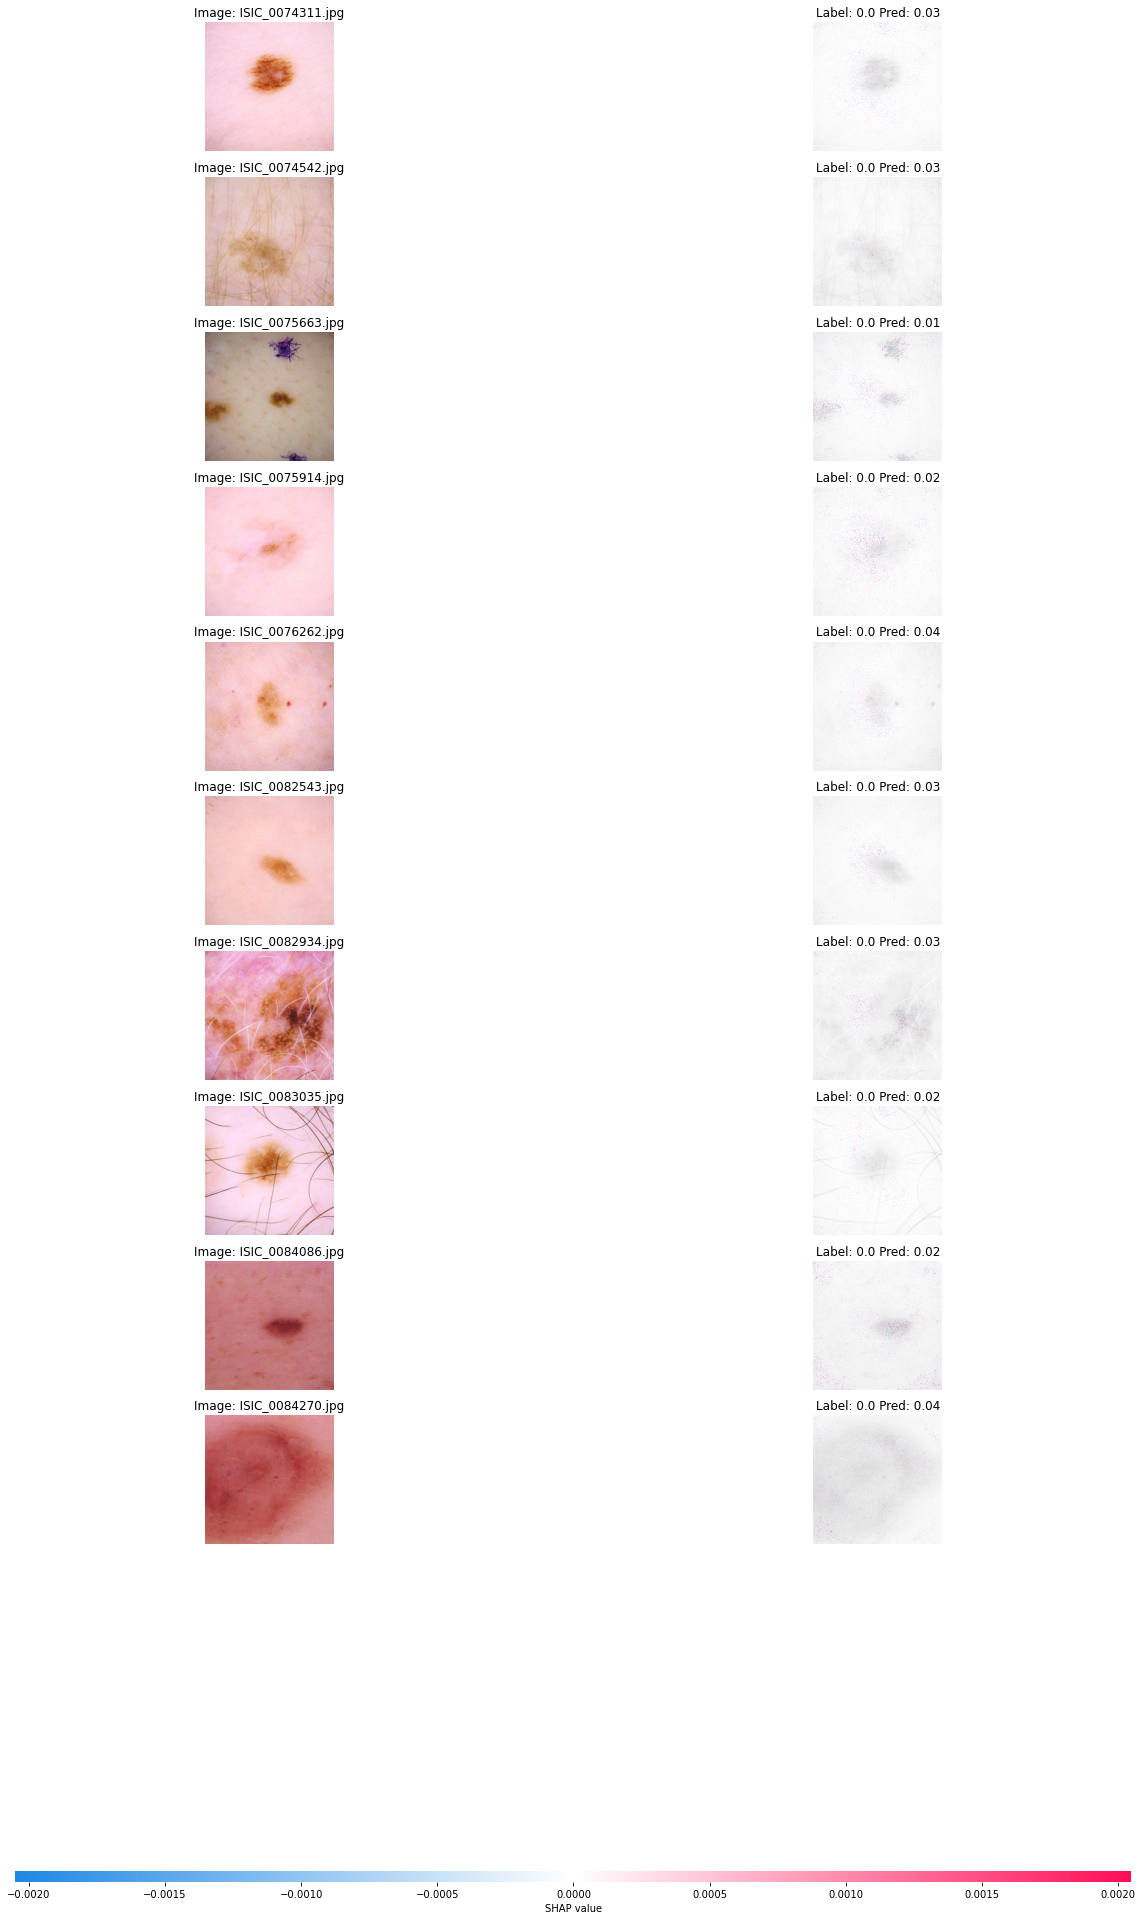

In [17]:
# explain predictions of the model on "n_explain" images
e = shap.GradientExplainer(model, background)
shap_values = e.shap_values(background)

# plot the feature attributions
image_plot(shap_values, background[:10], labels=lbls, preds=eval_df['preds'].values[:10].reshape(10, 1), names=eval_df['image_name'].values[:10], 
           hspace=0.2, fig_size=(20, 40))

At all the above images the prediction score was very low, which resulted in the explained images (right images) being mostly gray, if you look really close, you may see some pink dots. At the same time, we can notice that at least the model pays attention mainly to the skin marks.

One interesting thing here is that the model seems to do not care about hair or the mm scale.

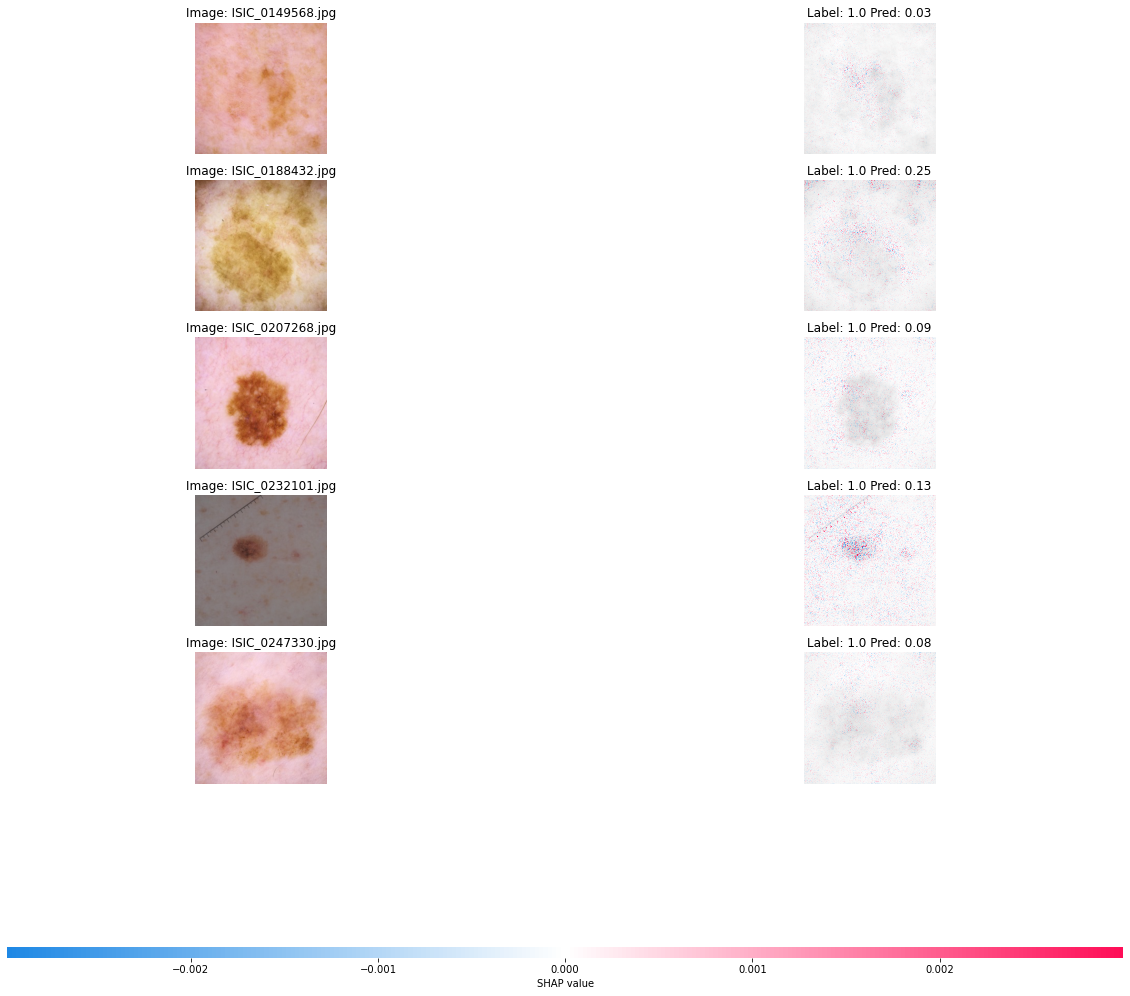

In [18]:
shap_values_positive = shap.GradientExplainer(model, background[10:15]).shap_values(background[10:15])

# plot the feature attributions
image_plot(shap_values_positive, background[10:15], labels=lbls[10:15], preds=eval_df['preds'].values[10:15].reshape(5, 1), 
           names=eval_df['image_name'].values[10:15], fig_size=(20, 20))

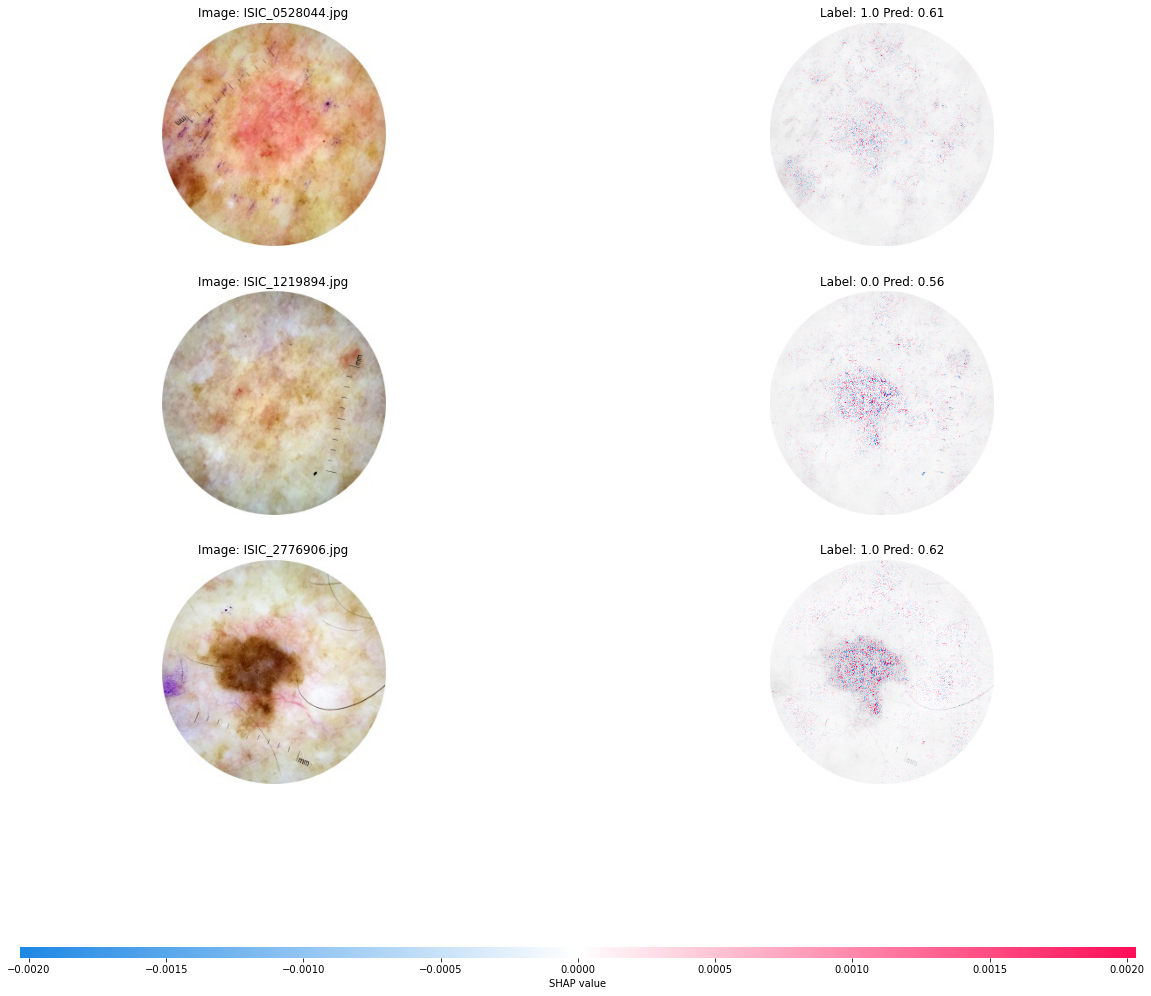

In [19]:
shap_values_positive = shap.GradientExplainer(model, background[-3:]).shap_values(background[-3:])

# plot the feature attributions
image_plot(shap_values_positive, background[-3:], labels=lbls[-3:], preds=eval_df['preds'].values[-3:].reshape(3, 1), 
           names=eval_df['image_name'].values[-3:], fig_size=(20, 20))

In [20]:
test_dataset = get_test_dataset(TEST_FILENAMES, batch_size=BATCH_SIZE, buffer_size=AUTO)
image_names = next(iter(test_dataset.unbatch().map(lambda data, image_name: image_name).batch(len(test)))).numpy().astype('U')

test_preds = model.predict(test_dataset)

name_preds = dict(zip(image_names, test_preds.reshape(len(test_preds))))
test['target'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)


print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")
print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge','target']].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target']].query('target > .5').head(10))


submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']
submission.to_csv('submission.csv', index=False)

76/76 [==============================] - 96s 1s/step


KeyError: 'ISIC_0074618'